In [1]:
using Pkg; Pkg.activate("")

 Activating environment at `~/work/covid/Project.toml`


In [43]:
using HTTP, CSV

using Query, DataFrames

using LinearAlgebra
using LsqFit

using Plots; gr()
using Reel

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1260


In [4]:
url_cases = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
url_counties = "https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv"

"https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv"

In [5]:
function query(url)
    response = HTTP.get(url)
    return CSV.read(response.body)
end

query (generic function with 1 method)

In [6]:
counties = query(url_counties)
cases = query(url_cases);

In [7]:
counties_hamburg = counties |> @filter(_.GEN == "Hamburg") |> DataFrame
cases_hamburg = cases |> @filter(_.Bundesland == "Hamburg") |> @orderby(_.Meldedatum) |> DataFrame;

In [8]:
println("Counties columns: ", names(counties_hamburg))
println("Cases coulmns: ", names(cases_hamburg))

Counties columns: [:OBJECTID, :ADE, :GF, :BSG, :RS, :AGS, :SDV_RS, :GEN, :BEZ, :IBZ, :BEM, :NBD, :SN_L, :SN_R, :SN_K, :SN_V1, :SN_V2, :SN_G, :FK_S3, :NUTS, :RS_0, :AGS_0, :WSK, :EWZ, :KFL, :DEBKG_ID, :Shape__Area, :Shape__Length, :death_rate, :cases, :deaths, :cases_per_100k, :cases_per_population, :BL, :BL_ID, :county, :last_update]
Cases coulmns: [:IdBundesland, :Bundesland, :Landkreis, :Altersgruppe, :Geschlecht, :AnzahlFall, :AnzahlTodesfall, :ObjectId, :Meldedatum, :IdLandkreis, :Datenstand, :NeuerFall, :NeuerTodesfall]


In [9]:
cases_hamburg_daily = cases_hamburg |>
    @groupby(_.Meldedatum) |>
    @map({
        Meldatum=_.Meldedatum[1][6:10],
        DayAnzahlFall=sum(_.AnzahlFall),
        DayAnzahlTodesfall=sum(_.AnzahlTodesfall)
    }) |>
    DataFrame

cases_hamburg_daily[!, :AnzahlFallCS] = cumsum(cases_hamburg_daily[!, :DayAnzahlFall])
cases_hamburg_daily[!, :AnzahlTodesfallCS] = cumsum(cases_hamburg_daily[!, :DayAnzahlTodesfall])

cases_hamburg_daily

,Meldatum,DayAnzahlFall,DayAnzahlTodesfall,AnzahlFallCS,AnzahlTodesfallCS
,String,Int64,Int64,Int64,Int64
1,02-23,1,0,1,0
2,02-29,1,0,2,0
3,03-01,1,0,3,0
4,03-03,1,0,4,0
5,03-04,3,0,7,0
6,03-05,5,0,12,0
7,03-06,2,0,14,0
8,03-07,3,0,17,0
9,03-08,5,0,22,0


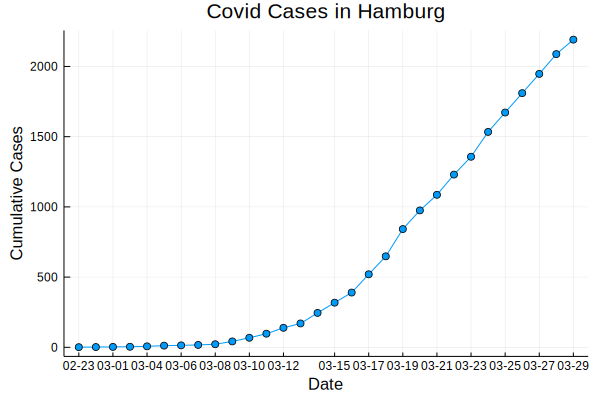

In [77]:
plot(cases_hamburg_daily[!, :Meldatum], cases_hamburg_daily[!, :AnzahlFallCS], legend=false, marker=true)
xlabel!("Date")
ylabel!("Cumulative Cases")
title!("Covid Cases in Hamburg")

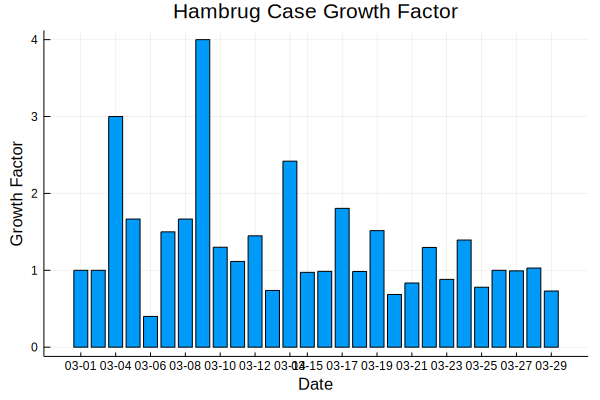

In [80]:
growth_factor(data) = diff(data)[2:end] ./ diff(data)[1:end-1]

bar(cases_hamburg_daily[!, :Meldatum][3:end], growth_factor(cases_hamburg_daily[!, :AnzahlFallCS]),
    legend=false)
xlabel!("Date")
ylabel!("Growth Factor")
title!("Hambrug Case Growth Factor")

In [81]:
frame_data = repeat(cumsum(cases_hamburg_daily[!, :AnzahlFallCS]), 1, length(cases_hamburg_daily[!, :AnzahlFallCS]))
frame_data = UpperTriangular(frame_data)
frame_data =  Array{Union{Missing, Int64},2}(frame_data)
frame_data[frame_data .== 0] .= missing
frame_data;

┌ Info: Saved animation to 
│   fn = /home/roscar/work/covid/tmp.gif
└ @ Plots /home/roscar/.julia/packages/Plots/rNwM4/src/animation.jl:98


Plots.AnimatedGif("/home/roscar/work/covid/tmp.gif")
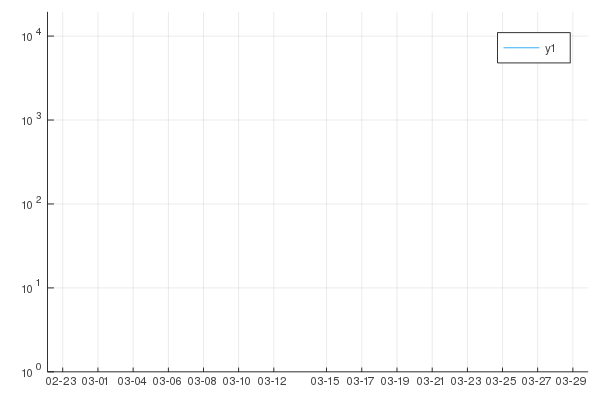

In [82]:
ylims = (1, maximum(skipmissing(frame_data)))

anim = @animate for i ∈ 1:size(frame_data)[2]
    plot(
        cases_hamburg_daily[!, :Meldatum], frame_data[:, i],
        yscale=:log10, ylims=ylims
    )
end

gif(anim, fps=15)

In [174]:
pure_exponential(t, p) = p[1] * exp.(p[2] * t)
pure_exponential_fit = curve_fit(pure_exponential, 1:30, cases_hamburg_daily[!, :AnzahlFallCS], [0.5, 0.5])

pure_exponential_fit.param

2-element Array{Float64,1}:
 57.75752224598727
  0.12553172210597932

In [181]:
logistic(t, p) = p[1] ./ (p[2] .+ (p[3] * exp.(p[4] * t)))
logistic_fit = curve_fit(logistic, collect(1:30), cases_hamburg_daily[!, :AnzahlFallCS], [0.5, 0.5, 0.5, 0.5])

logistic_fit.param

4-element Array{Float64,1}:
 12.8511410128795
  0.005201652510885756
  2.5277267609302845
 -0.2690555844207649

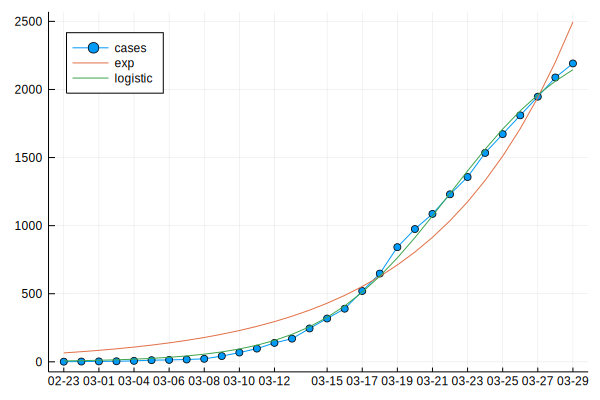

In [182]:
plot(cases_hamburg_daily[!, :Meldatum], cases_hamburg_daily[!, :AnzahlFallCS], marker=true, label="cases")

plot!(cases_hamburg_daily[!, :Meldatum], pure_exponential(1:30, pure_exponential_fit.param), label="exp")
plot!(cases_hamburg_daily[!, :Meldatum], logistic(1:30, logistic_fit.param), label="logistic", legend=:topleft)

In [178]:
logistic(1:35, logistic_fit.param)[end-6:end]

7-element Array{Float64,1}:
 2061.2453360436475
 2145.086664942308
 2213.894195770217
 2269.5199325059434
 2313.9444258052217
 2349.0791686796233
 2376.653203178359

In [192]:
ci = confidence_interval(logistic_fit, 0.1)

ci_lower = [c[1] for c in ci]
ci_upper = [c[2] for c in ci]

4-element Array{Float64,1}:
      3.9897841530462406e6
   1614.9106945202657
 784760.5517430637
     -0.23297860468401313

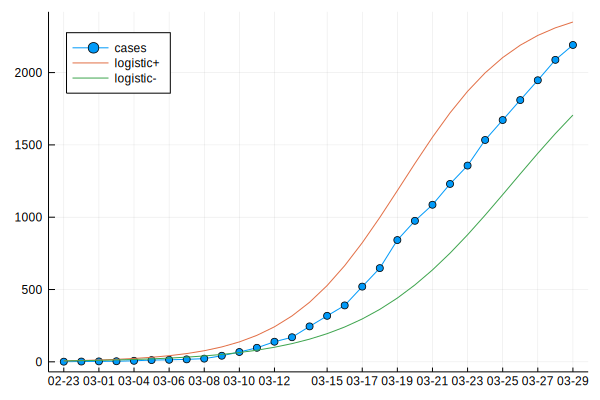

In [193]:
plot(cases_hamburg_daily[!, :Meldatum], cases_hamburg_daily[!, :AnzahlFallCS], marker=true, label="cases")
plot!(cases_hamburg_daily[!, :Meldatum], logistic(1:30, ci_lower), label="logistic+", legend=:topleft)
plot!(cases_hamburg_daily[!, :Meldatum], logistic(1:30, ci_upper), label="logistic-", legend=:topleft)